In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from collections.abc import Generator    #Abstract Base Classes for Containers (för kurviga scratches)
import cv2 as cv            #(för kurviga scratches)
from torchvision.utils import save_image

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [84]:
from PIL import Image, ImageDraw, ImageEnhance, ImageFilter

def apply_sepia(img_array):
    filter = np.array([[0.393, 0.769, 0.189],  # Red Channel
                       [0.349, 0.686, 0.168],  # Green Channel
                       [0.272, 0.534, 0.131]]) # Blue Channel
    sepia_img = np.dot(img_array, filter.T)
    sepia_img = np.where(sepia_img > 255, 255, sepia_img)
    return sepia_img.astype(np.uint8)

def apply_noise(img_array, strength=30):
    mean = 0
    var = strength
    sigma = var ** 0.5
    gaussian = np.random.normal(mean, sigma, img_array.shape)
    noisy_img = img_array + gaussian
    noisy_img = np.clip(noisy_img, 0, 255)
    return noisy_img.astype(np.uint8)

def apply_vignette(img_array):
    height, width = img_array.shape[:2]
    x = np.arange(width)
    y = np.arange(height)
    x_grid, y_grid = np.meshgrid(x, y)
    center_x, center_y = width / 2, height / 2
    radius = np.sqrt(center_x**2 + center_y**2)
    vignette = ((radius - np.sqrt((x_grid - center_x)**2 + (y_grid - center_y)**2)) / radius)
    vignette_power = 0.5
    vignette = vignette ** vignette_power
    vignette = np.stack([vignette] * 3, axis=-1)
    vignette_img = img_array * vignette
    vignette_img = np.clip(vignette_img, 0, 255)
    return vignette_img.astype(np.uint8)

def draw_random_line(img):
    draw = ImageDraw.Draw(img)
    width, height = img.size
    start = (random.randint(0, width), random.randint(0, height))
    end = (random.randint(0, width), random.randint(0, height))
    draw.line([start, end], fill='black', width=3)
    return img

def remove_random_corner(img):
    draw = ImageDraw.Draw(img)
    width, height = img.size
    corner = random.choice([
        (0, 0, width//3, height//3),
        (2*width//3, 0, width, height//3),
        (0, 2*height//3, width//3, height),
        (2*width//3, 2*height//3, width, height)
    ])
    draw.rectangle(corner, fill='black')
    return img

def apply_damage_effect(img_array, effect_type='line'):
    img = Image.fromarray(img_array)
    if effect_type == 'line':
        img = draw_random_line(img)
    elif effect_type == 'corner':
        img = remove_random_corner(img)
    return np.array(img)


def apply_blur(img_array):
    # Convert NumPy array to PIL Image
    img = Image.fromarray(img_array.astype('uint8'))
    # Apply Gaussian blur
    blurred_img = img.filter(ImageFilter.GaussianBlur(radius=1))
    # Convert PIL Image back to NumPy array
    return np.array(blurred_img)

def apply_stains(img_array):
    img = Image.fromarray(img_array.astype('uint8'))
    draw = ImageDraw.Draw(img)
    num_stains = random.randint(1, 5)  # You can adjust the number of stains if needed
    for _ in range(num_stains):
        # Starting points for the ellipse
        x0 = random.randint(0, img.width)
        y0 = random.randint(0, img.height)
        # End points for the ellipse are now closer to the starting points for smaller stains
        x1 = x0 + random.randint(25, 75)  # Smaller range for width of stains
        y1 = y0 + random.randint(25, 75)  # Smaller range for height of stains
        draw.ellipse([x0, y0, x1, y1], fill='brown', outline='brown')
    return np.array(img)

#def apply_scratches(img_array):
#    img = Image.fromarray(img_array.astype('uint8'))  # Convert numpy array to PIL Image
#    draw = ImageDraw.Draw(img)
#    for _ in range(random.randint(1, 10)):  # Random number of scratches
#        start = (random.randint(0, img.width), random.randint(0, img.height))
#        end = (random.randint(0, img.width), random.randint(0, img.height))
#        draw.line([start, end], fill='white', width=random.randint(1, 3))
#    return np.array(img)  # Convert back to numpy array if needed

#används av apply_scratches för att skapa kurviga scratches (hör till funktionen nedan)
def bezier(p1: np.ndarray, p2: np.ndarray, p3: np.ndarray) -> Generator[np.ndarray, None, None]:
    def calc(t):
        return t * t * p1 + 2 * t * (1 - t) * p2 + (1 - t) * (1 - t) * p3

    # get the approximate pixel count of the curve
    approx = cv.arcLength(np.array([calc(t)[:2] for t in np.linspace(0, 1, 10)], dtype=np.float32), False)
    for t in np.linspace(0, 1, round(approx * 1.2)):
        yield np.round(calc(t)).astype(np.int32)

def apply_scratches(img_array):
    H = img_array.shape[0]
    W = img_array.shape[1]
    max_length = 1000  # maximum distance between two end points
    end_brush_range = (0, 1)  # brush size range of the two end points
    mid_brush_range = (2, 5)  # brush size range of the mid point
    scratch_count = 5

    for _ in range(scratch_count):

        # generate the 2 end points of the bezier curve
        x, y, rho1, theta1 = np.random.uniform([0] * 4, [W, H, max_length, np.pi * 2])
        p1 = np.array([x, y, 0])
        p3 = p1 + [rho1 * np.cos(theta1), rho1 * np.sin(theta1), 0]
        # generate the second point, make sure that it cannot be too far away from the middle point of the 2 end points
        rho2, theta2 = np.random.uniform([0], [rho1 / 2, np.pi * 2])
        p2 = (p1 + p3) / 2 + [rho2 * np.cos(theta2), rho2 * np.sin(theta2), 0]
        # generate the brush sizes of the 3 points
        p1[2], p2[2], p3[2] = np.random.uniform(*np.transpose([end_brush_range, mid_brush_range, end_brush_range]))

        for x, y, brush in bezier(p1, p2, p3):
            cv.circle(img_array, (x, y), brush, (255, 255, 255), -1)
    return np.array(img_array)

def apply_fading(img_array):
    img = Image.fromarray(img_array.astype('uint8'), 'RGB')  # Convert numpy array to PIL Image
    converter = ImageEnhance.Color(img)
    img_faded = converter.enhance(0.5)  # Reduce color saturation by 50%
    return np.array(img_faded)  # Convert back to numpy array if needed


def apply_combined_effects(img_array, number_of_effects=5):
    # List of all possible effects with appropriate function and any required arguments
    list_of_effects = [
        #(apply_sepia, {}),
        (apply_noise, {'strength': 30}),
        #(apply_vignette, {}),
        #(apply_damage_effect, {'effect_type': 'line'}),
        (apply_fading, {}),
        (apply_blur, {}),
        (apply_stains, {}),
        (apply_scratches, {})
    ]

    # Shuffle and pick the specified number of effects to apply
    random.shuffle(list_of_effects)
    selected_effects = list_of_effects[:number_of_effects]

    for effect_function, kwargs in selected_effects:
        img_array = effect_function(img_array, **kwargs)

    return img_array


def process_image(image_path, output_dir, effect_name, number_of_effects):
    image = Image.open(image_path)
    img_array = np.array(image)
    processed_img_array = apply_combined_effects(img_array, number_of_effects)
    output_path = os.path.join(output_dir, f"{effect_name}_{os.path.basename(image_path)}")
    Image.fromarray(processed_img_array).save(output_path)

input_dir = r'C:\Users\oskar\OneDrive\Dokument\repo\TIF360-Project\test_images\real'
output_dir = r'C:\Users\oskar\OneDrive\Dokument\repo\TIF360-Project\test_images\fake'
effect_name = "combined_effects"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process each image in the directory
for filename in os.listdir(input_dir):
    if filename.endswith(".png"):  # You can adjust the file extension as needed
        input_path = os.path.join(input_dir, filename)
        process_image(input_path, output_dir, effect_name, number_of_effects=5)

In [69]:
def apply_combined_effects(img_array, number_of_effects=1):
    # List of all possible effects with appropriate function and any required arguments
    list_of_effects = [
        (apply_sepia, {})
        # (apply_noise, {'strength': 30}),
        # #(apply_vignette, {}),
        # #(apply_damage_effect, {'effect_type': 'line'}),
        # (apply_fading, {}),
        # (apply_blur, {}),
        # (apply_stains, {}),
        # (apply_scratches, {})
    ]
def process_image(image_path, output_dir, effect_name, number_of_effects):
    image = Image.open(image_path)
    img_array = np.array(image)
    processed_img_array = apply_combined_effects(img_array, number_of_effects)
   
    Image.fromarray(processed_img_array).save(f'test_images\fake\combined_effects_00045.png')

input_dir = f'test_images\fake\combined_effects_00045.png'
output_dir = r'test_images\fake\combined_effects_00045.png'
effect_name = "combined_effects"

# Ensure output directory exists

process_image(input_path, output_dir, effect_name, number_of_effects=1)

AttributeError: 'NoneType' object has no attribute '__array_interface__'

In [2]:

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PairedImageDataset(Dataset):
    def __init__(self, root_dir_1, root_dir_2, transform=None):
        self.root_dir_1 = root_dir_1
        self.root_dir_2 = root_dir_2
        self.transform = transform
        self.image_files_1 = sorted(os.listdir(root_dir_1))
        self.image_files_2 = sorted(os.listdir(root_dir_2))
        print(len(self.image_files_1))
        print(len(self.image_files_2))
        assert len(self.image_files_1) == len(self.image_files_2), "Number of images in both directories must be the same"

    def __len__(self):
        return len(self.image_files_1)

    def __getitem__(self, idx):
        img1_name = os.path.join(self.root_dir_1, self.image_files_1[idx])
        img2_name = os.path.join(self.root_dir_2, self.image_files_2[idx])
        
        img1 = Image.open(img1_name)
        img2 = Image.open(img2_name)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2

# Define transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to the desired size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

# Create an instance of the dataset
dataset = PairedImageDataset(root_dir_1=r'test_real', root_dir_2=r'test_real', transform=transform)

# Create a DataLoader to iterate over the dataset in batches
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


8
8


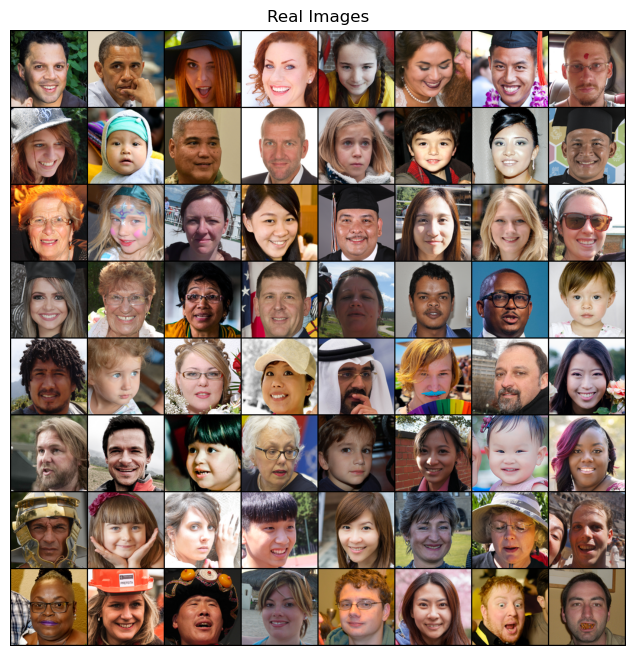

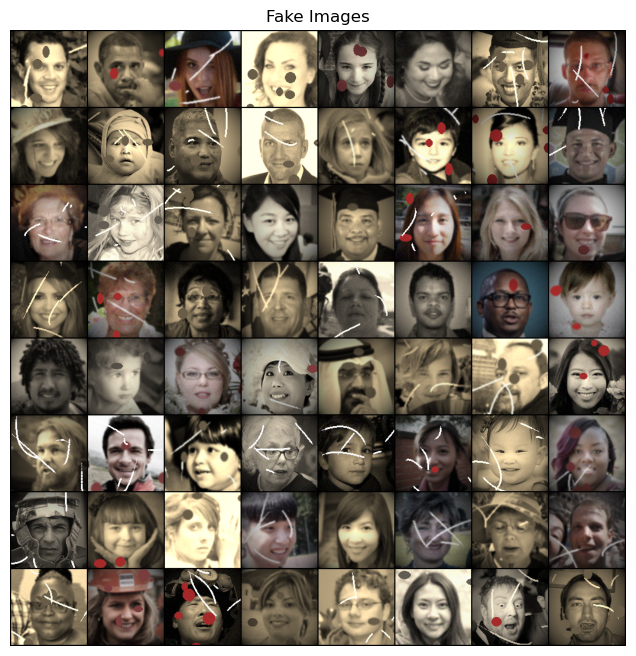

In [97]:
real_batch, fake_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_batch[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:


class Discriminator(nn.Module):
    def __init__(self, output_channels):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            
            nn.Conv2d(output_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
           
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64*2, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
           
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
           
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [6]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()

        # downsize image (Encoder)

        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #downsampling

        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4, stride=2,padding=1), #downsampling

        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4, stride=2,padding=1), #downsampling

        )
        self.encoder4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4, stride=2,padding=1), #downsampling

        )
        self.decoder1 = nn.Sequential(


            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2,padding=1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Upsampling
            nn.ReLU(inplace=True),
        )
        self.decoder2 = nn.Sequential(


            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2,padding=1),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Upsampling
            nn.ReLU(inplace=True),
        )
        self.decoder3 = nn.Sequential(


            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2,padding=1),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Upsampling
            nn.ReLU(inplace=True),
        )
        self.decoder4 = nn.Sequential(

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Upsampling
            nn.ReLU(inplace=True),
        )

        # Output layer
        self.output = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)

    def forward(self, x):

        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)


        x = self.decoder1(x4)
        x = self.decoder2(x + x3) #added skipconnection
        x = self.decoder3(x + x2) #added skipconnection
        x = self.decoder4(x + x1)
        x = self.output(x)
        return x


In [4]:

netD = torch.load(r"network\discriminator_scripted.pt", map_location=torch.device('cpu'))
netG = torch.load("generator_scripted (2).pt", map_location=torch.device('cpu'))
# netG.apply(weights_init)
# netD.apply(weights_init)
print(netG)
print(netD)

c:\Users\oskar\anaconda3\lib\site-packages\torch\serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


RecursiveScriptModule(
  original_name=Generator
  (encoder1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=Conv2d)
    (2): RecursiveScriptModule(original_name=BatchNorm2d)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=MaxPool2d)
  )
  (encoder2): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=Conv2d)
    (2): RecursiveScriptModule(original_name=BatchNorm2d)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=MaxPool2d)
  )
  (encoder3): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=Conv2d)
    (2): RecursiveScriptModule(original_name=BatchNorm2d)
    (3): RecursiveScriptModule(original

In [25]:
# Initialize the ``BCELoss`` function
lr = 0.0002
beta1 = 0.5
criterion = nn.BCELoss()
img_criterion = nn.L1Loss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
real, fake = next(iter(dataloader))
fixed_faces = fake
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [27]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
img_losses = []
iters = 0
num_epochs = 1
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        real_image, fake_image = data
        
        # (1) Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = real_image
        fake_cpu = fake_image
        #real_cpu = data[0]
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        fake = netG(fake_image)
    
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        
        # (2) Update Generator: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)

        lossImg = img_criterion(fake,real_cpu) * 10

        lossG = errG + lossImg
        # Calculate gradients for G
        lossG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_img:%.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(),lossImg.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        img_losses.append(lossImg.item())
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_faces).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        

Starting Training Loop...


ValueError: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([6291456])) is deprecated. Please ensure they have the same size.

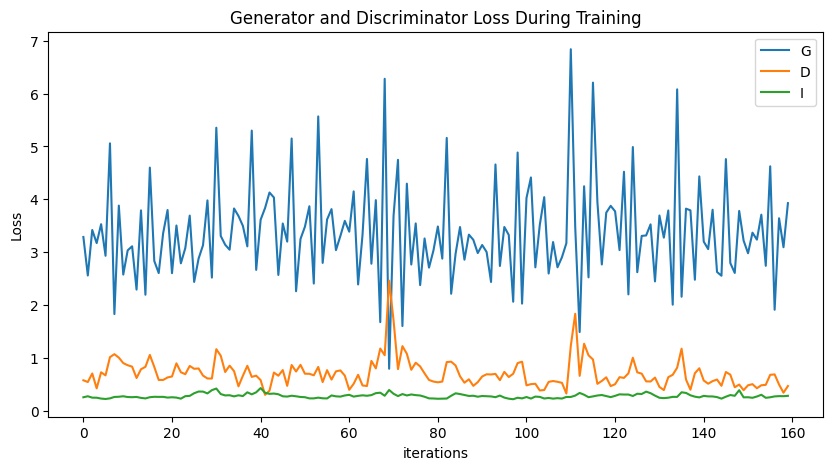

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(img_losses,label="I")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: name 'img_list' is not defined

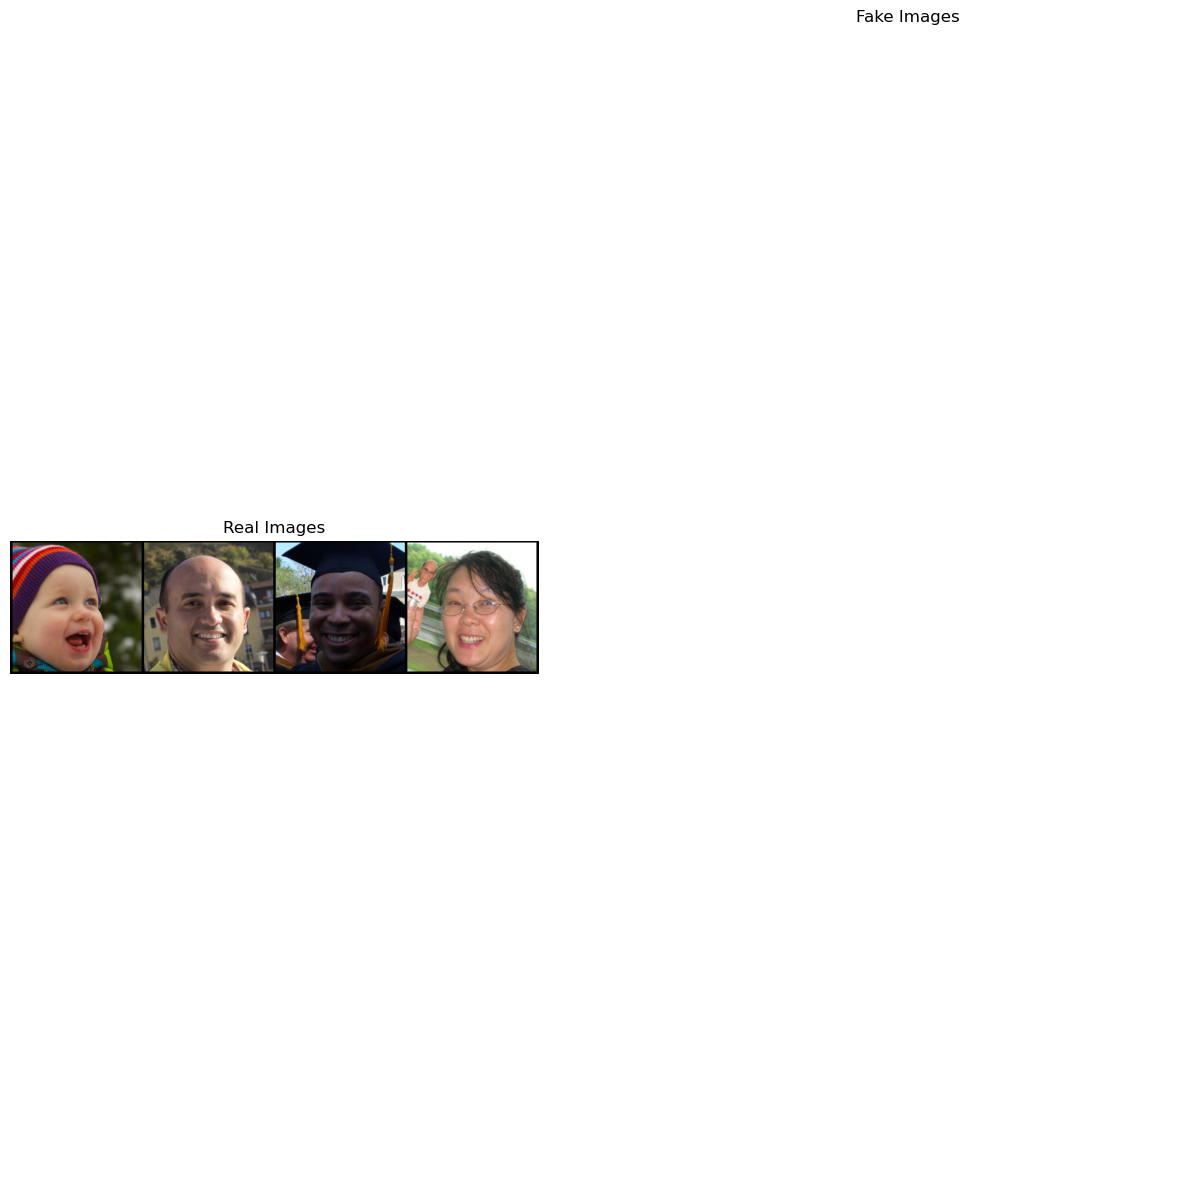

In [38]:
real_batch,fake_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


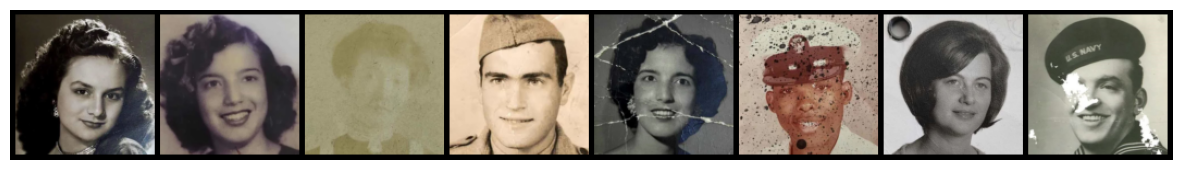

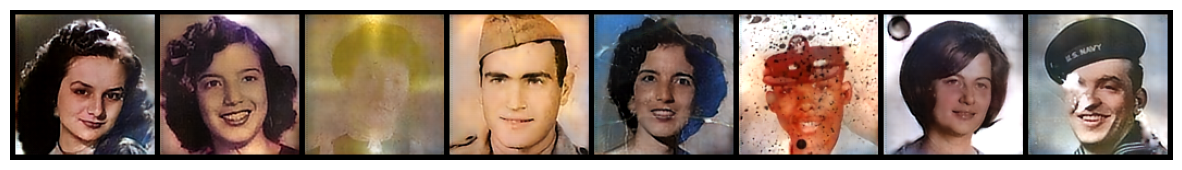

In [5]:
real_batch,fake_batch = next(iter(dataloader))
fake = netG(fake_batch)
img  = fake.detach()
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

# Assuming you have already defined real_batch, fake_batch, and img

# Plot and save fake images
plt.figure(figsize=(15,15))
plt.axis("off")

plt.imshow(np.transpose(vutils.make_grid(fake_batch[:32], padding=5, normalize=True).cpu(),(1,2,0)))
plt.savefig("fake_images.png",bbox_inches='tight', pad_inches=0)  # Saving the fake images grid as an image

# # Plot and save real images
# plt.figure(figsize=(15,15))
# plt.axis("off")

# plt.imshow(np.transpose(vutils.make_grid(real_batch[:16], padding=5, normalize=True).cpu(),(1,2,0)))
# plt.savefig("real_images.png",bbox_inches='tight', pad_inches=0)  # Saving the real images grid as an image

# Plot and save generated images
plt.figure(figsize=(15,15))
plt.axis("off")

plt.imshow(np.transpose(vutils.make_grid(img[:32], padding=5).cpu(),(1,2,0)))
plt.savefig("generated_images.png",bbox_inches='tight', pad_inches=0)  # Saving the generated images grid as an image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


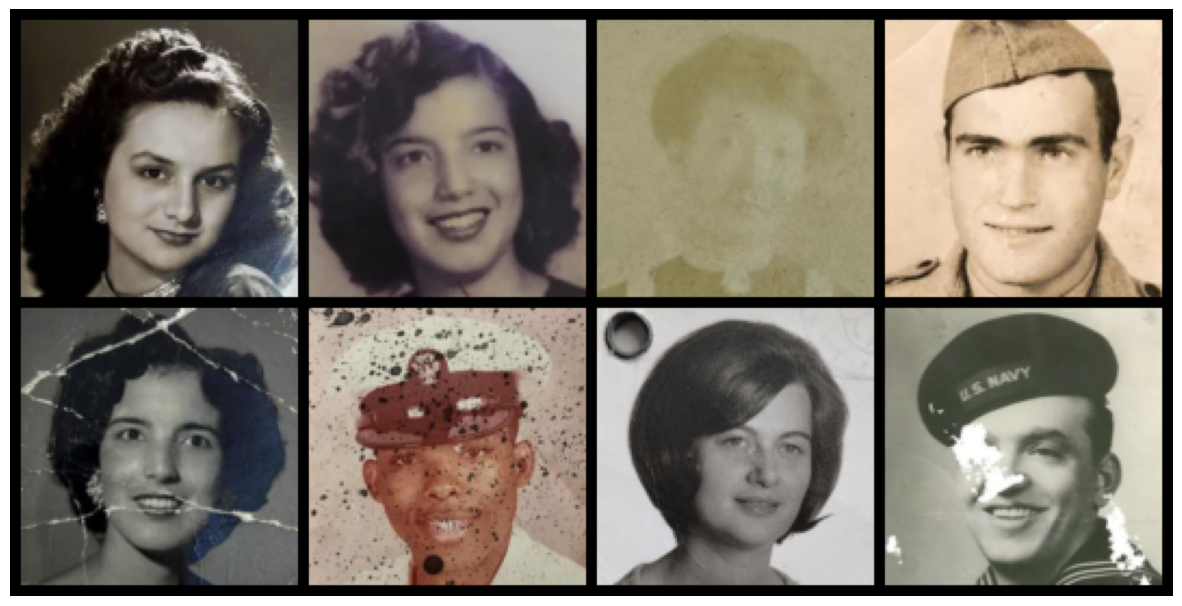

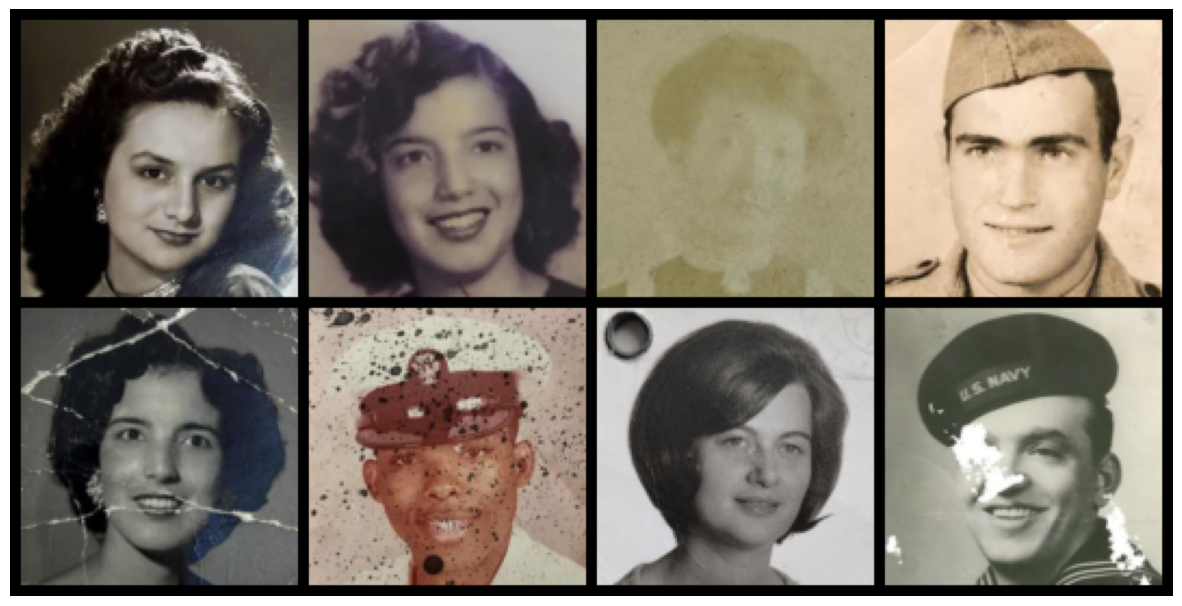

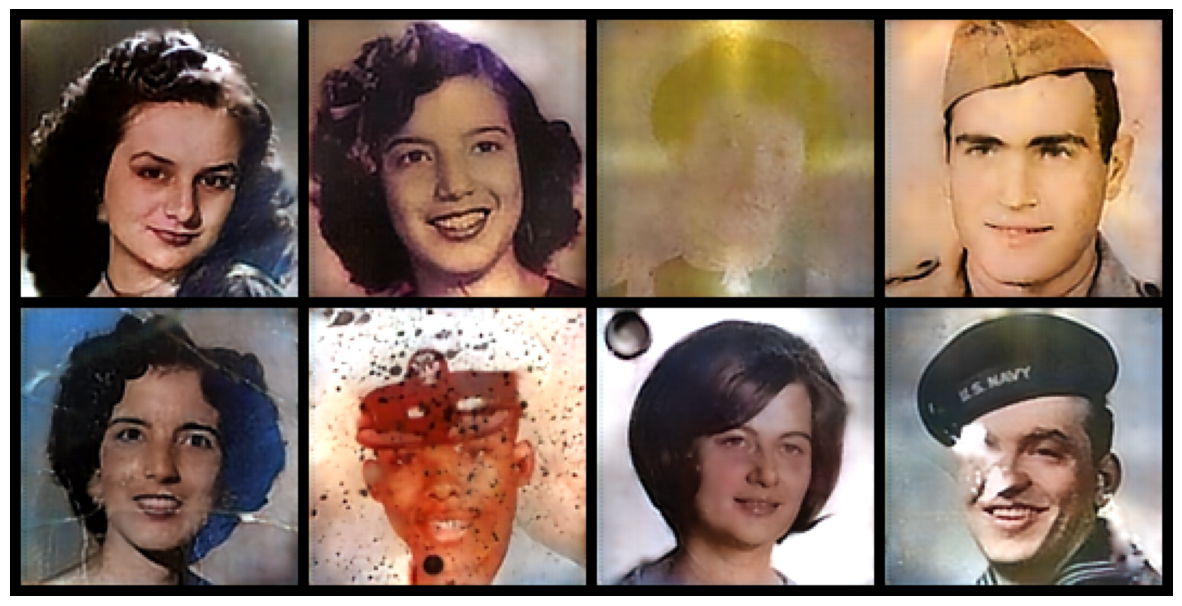

In [6]:
plt.figure(figsize=(15,15))
plt.axis("off")

plt.imshow(np.transpose(vutils.make_grid(fake_batch[:8], padding=5,nrow=4, normalize=True).cpu(),(1,2,0)))
plt.savefig("fake_images.png",bbox_inches='tight', pad_inches=0)  # Saving the fake images grid as an image

# # Plot and save real images
plt.figure(figsize=(15,15))
plt.axis("off")

plt.imshow(np.transpose(vutils.make_grid(real_batch[:8], padding=5,nrow=4, normalize=True).cpu(),(1,2,0)))
plt.savefig("real_images.png",bbox_inches='tight', pad_inches=0)  # Saving the real images grid as an image

# Plot and save generated images
plt.figure(figsize=(15,15))
plt.axis("off")

plt.imshow(np.transpose(vutils.make_grid(img[:8], padding=5,nrow=4).cpu(),(1,2,0)))
plt.savefig("generated_images.png", bbox_inches='tight', pad_inches=0)  # Saving the generated images grid as an image

In [106]:
import ssim_loss

ssim_loss = ssim_loss.SSIM()



ModuleNotFoundError: No module named 'mxnet'